In [1]:
# start to let c_EC affect j_SEI - start from solvent diffusion limited
# how?  
# 1. change: elif self.options["SEI"] == "solvent-diffusion limited": in sei_growth.py
# 2. change: self.C_sei_solvent in lithium_ion_parameters.py
# 3. now have long term cycling 

In [2]:
import pybamm as pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os; #import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

In [3]:
V_max = 4.2;        V_min = 2.5;
Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 0.3 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 20 )  
save_at_cycles= 5

In [4]:
Model_0 = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",               
        "solvent diffusion": "EC"     } )
Model_1 = pybamm.lithium_ion.DFN(     
    options={      
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",   
        "solvent diffusion": "none"     } )
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008_rio";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);

Para_0.update({'EC transference number':-1.4})
Para_0.update({'EC Lithium ion cross diffusivity [m2.s-1]':1.5e-9/1e2})
Para_0.update({'Typical EC Lithium ion cross diffusivity [m2.s-1]':1.5e-9/1e2})
Para_0.update({'EC diffusivity in electrolyte [m2.s-1]':3E-10})
Para_0.update({'Electrolyte diffusivity [m2.s-1]':3e-10})

Confirm: using solvent-diffusion limited
have you come here?
Confirm: using solvent-diffusion limited


In [5]:
# control SEI rate
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':4e-19})

Para_0.search("diffusivity")
gamma_e_ec_Rio = Para_0.evaluate(Model_0.param.gamma_e_ec_Rio)  
print(gamma_e_ec_Rio)

In [6]:
Sim_0    = pybamm.Simulation(
    Model_0, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_0    = Sim_0.solve(save_at_cycles=save_at_cycles,);
Sim_1    = pybamm.Simulation(
    Model_1, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_1    = Sim_1.solve(save_at_cycles=save_at_cycles,);

In [7]:
Model_0.variables.search('loss of')

Loss of active material in negative electrode [%]
Loss of active material in positive electrode [%]
Loss of capacity to SEI [A.h]
Loss of capacity to SEI on cracks [A.h]
Loss of capacity to lithium plating [A.h]
Loss of lithium inventory [%]
Loss of lithium inventory, including electrolyte [%]
Loss of lithium to SEI [mol]
Loss of lithium to SEI on cracks [mol]
Loss of lithium to lithium plating [mol]


In [8]:
print(Sol_1.cycles[-1]["EC concentration [mol.m-3]"].entries[:,-1])
print(Sol_1.cycles[0]["EC concentration [mol.m-3]"].entries[:,-1])

[4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.]
[4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.
 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541. 4541.]


In [11]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "Total EC in electrolyte [mol]",
    #"Total lithium in electrolyte [mol]",
    "Loss of capacity to SEI [A.h]",
    #"Discharge capacity [A.h]",
    "Total EC in electrolyte and SEI [mol]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=76.28450366357507, step=0.7628450366357507),…

ValueError: x and y must have same first dimension, but have shapes (1,) and (1165,)

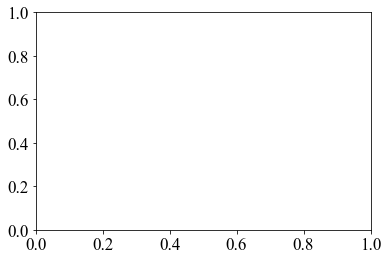

In [10]:
total_EC_w_SEI = Sol_0["Total EC in electrolyte [mol]"].entries + Sol_0["Loss of lithium to SEI [mol]"].entries
Time = Sol_0["Time [h]"]
plt.plot(Time,total_EC_w_SEI)

In [ ]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    #"Terminal voltage [V]",   
    "Negative electrode SEI interfacial current density [A.m-2]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();